In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [13]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [14]:
# dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [15]:
if not os.path.isdir('./motif_enrichment_heatmaps/'):
    os.mkdir('./motif_enrichment_heatmaps/')

In [16]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_all.txt', sep='\t')

# Explore data a bit - this is a much easier way to compare results of known motif analysis

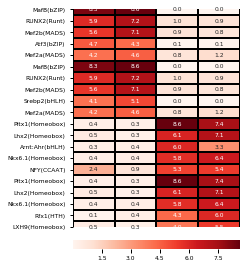

In [17]:
top_n = 5


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('trans')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})
    

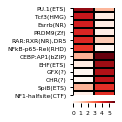

In [21]:
# top_n = 6


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('mixed')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(0.75,2))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=False,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

plt.savefig('./figures/atac_mixed_distal_enrichment.pdf',
            bbox_inches='tight')

In [31]:
df.columns

Index(['atac_mixed_balb_hunterFCThenPadj_distal_motifs', 'atac_mixed_c57_hunterFCThenPadj_distal_motifs'], dtype='object')

In [33]:
((df)<np.log(0.05)).any(1).sum()

31

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


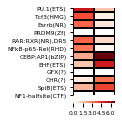

In [32]:
# top_n = 6


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, ~ df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('mixed')]
# only significant
df = df.loc[((df)<np.log(0.05)).any(1), :]

fig, ax = plt.subplots(figsize=(0.75,2))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=False,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

plt.savefig('./figures/atac_mixed_distal_enrichment_sig_only.pdf',
            bbox_inches='tight')

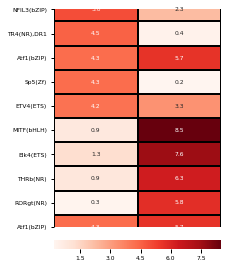

In [19]:
top_n = 5


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('cis')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

It seems like mixed motifs for balbcj correlate decently well with trans motifs for c57...

In [9]:
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, ~df.columns.str.contains('distal')]
df.columns

Index(['atac_cis_balb_hunterFCThenPadj_motifs',
       'atac_cis_c57_hunterFCThenPadj_motifs',
       'atac_mixed_balb_hunterFCThenPadj_motifs',
       'atac_mixed_c57_hunterFCThenPadj_motifs',
       'atac_trans_balb_hunterFCThenPadj_motifs',
       'atac_trans_c57_hunterFCThenPadj_motifs'],
      dtype='object')

In [10]:
df.columns

Index(['atac_cis_balb_hunterFCThenPadj_motifs',
       'atac_cis_c57_hunterFCThenPadj_motifs',
       'atac_mixed_balb_hunterFCThenPadj_motifs',
       'atac_mixed_c57_hunterFCThenPadj_motifs',
       'atac_trans_balb_hunterFCThenPadj_motifs',
       'atac_trans_c57_hunterFCThenPadj_motifs'],
      dtype='object')

In [11]:
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


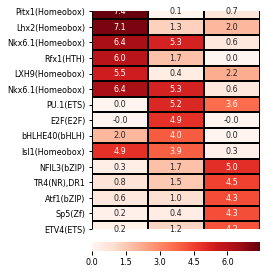

In [13]:
top_n = 5


# filter data
# df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
# df = df.loc[:, df.columns.str.contains('trans|mixed')]
df = known_motif_pval_frame.loc[:, ['atac_trans_c57_hunterFCThenPadj_motifs',
                                    'atac_mixed_balb_hunterFCThenPadj_motifs',
                                    'atac_cis_balb_hunterFCThenPadj_motifs']]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

d2 = dist.pdist(tmp_df.T)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)

sns.heatmap(tmp_df.iloc[:, Z2['leaves']],
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


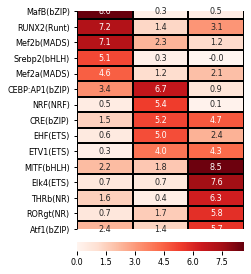

In [14]:
top_n = 5


# filter data
# df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
# df = df.loc[:, df.columns.str.contains('trans|mixed')]
df = known_motif_pval_frame.loc[:, ['atac_trans_balb_hunterFCThenPadj_motifs',
                                    'atac_mixed_c57_hunterFCThenPadj_motifs',
                                    'atac_cis_c57_hunterFCThenPadj_motifs']]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

d2 = dist.pdist(tmp_df.T)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)

sns.heatmap(tmp_df.iloc[:, Z2['leaves']],
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

In [46]:
from scipy.stats import spearmanr

In [47]:
spearmanr(-known_motif_pval_frame.loc[:, 'atac_%s_balb_hunterFCThenPadj_motifs' % settype],
                           -known_motif_pval_frame.loc[:, 'atac_%s_c57_hunterFCThenPadj_motifs'% settype])

SpearmanrResult(correlation=-0.06178048180476145, pvalue=0.2031585831883146)

Text(0.5, 0, 'BALB/cJ')

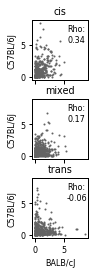

In [60]:

fig, axs = plt.subplots(3, 1, figsize=(1,4),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(hspace=0.33)

for settype, ax in zip(['cis', 'mixed', 'trans'], axs):

    ax.scatter(-known_motif_pval_frame.loc[:, 'atac_%s_balb_hunterFCThenPadj_motifs' % settype],
                   -known_motif_pval_frame.loc[:, 'atac_%s_c57_hunterFCThenPadj_motifs'% settype],
                   s=1,
                   c='#636363')
    
    corr = spearmanr(-known_motif_pval_frame.loc[:, 'atac_%s_balb_hunterFCThenPadj_motifs' % settype],
                            -known_motif_pval_frame.loc[:, 'atac_%s_c57_hunterFCThenPadj_motifs'% settype])
    
    ax.text(5.5, 5.5, 'Rho:\n%.2f' % corr.correlation)
    
    ax.set_ylabel('C57BL/6J')
    ax.set_title(settype)

# axs[0].set_xticks([])
# axs[1].set_xticks([])
axs[2].set_xlabel('BALB/cJ')


In [35]:
(-known_motif_pval_frame).corr(method='spearman').loc['atac_trans_balb_hunterFCThenPadj_motifs',
                 'atac_trans_c57_hunterFCThenPadj_motifs']

-0.06178048180476145

In [36]:
(-known_motif_pval_frame).corr(method='spearman').loc['atac_mixed_balb_hunterFCThenPadj_motifs',
                 'atac_mixed_c57_hunterFCThenPadj_motifs']

0.17459625134750764

In [37]:
(-known_motif_pval_frame).corr(method='spearman').loc['atac_cis_balb_hunterFCThenPadj_motifs',
                 'atac_cis_c57_hunterFCThenPadj_motifs']

0.3426876742953986